In [34]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import os
import PIL.ImageOps 
print(torch.__version__)  #1.1.0
print(torchvision.__version__)  #0.3.0


#定义一些超参
train_batch_size = 20        #训练时batch_size
train_number_epochs = 50     #训练的epoch

def imshow(img,text=None,should_save=False): 
    #展示一幅tensor图像，输入是(C,H,W)
    npimg = img.numpy() #将tensor转为ndarray
#     print(npimg.shape)
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #转换为(H,W,C)
    plt.show()    

def show_plot(iteration,loss):
    #绘制损失变化图
    plt.plot(iteration,loss)
    plt.title("Loss Function Line")
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()
def file_name(file_dir):
    for root,dirs,files in os.walk(file_dir):
        return files

1.11.0
0.12.0


In [28]:
#重写Dataset类，__getitem__(self,index)每次返回(img1, img2, 01标签)
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset1,imageFolderDataset2,transform=None,should_invert=True):
        self.imageFolderDataset1 = imageFolderDataset1
        self.imageFolderDataset2 = imageFolderDataset2
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset1.imgs) #10个套装中任选一
        should_get_same_class = random.randint(0,1) #保证同类样本约占一半
        if should_get_same_class:
            while True:
                #直到找到同一类别
                img1_tuple = random.choice(self.imageFolderDataset2.imgs)
                if img0_tuple[1]==img1_tuple[1]:
                    break

        else:
            while True:
                #直到找到非同一类别
                img1_tuple = random.choice(self.imageFolderDataset2.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break


        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset1.imgs)+len(self.imageFolderDataset1.imgs)
    
    
    
#定义文件dataset
training_dir1 = "./data2/train/1/"  #上衣训练集地址
folder_dataset1 = torchvision.datasets.ImageFolder(root=training_dir1)

training_dir2 = "./data2/train/2/"  #上衣训练集地址
folder_dataset2 = torchvision.datasets.ImageFolder(root=training_dir2)

#定义图像dataset
transform = transforms.Compose([transforms.Resize((100,100)),
                                transforms.ToTensor()])
siamese_dataset = SiameseNetworkDataset(imageFolderDataset1=folder_dataset1,
                                        imageFolderDataset2=folder_dataset2,
                                        transform=transform,
                                        should_invert=False)

#定义图像dataloader
train_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=train_batch_size)
print(len(folder_dataset1.imgs),len(folder_dataset2.imgs))

122 108


(3, 206, 818)


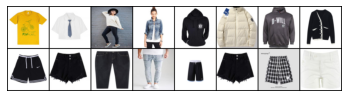

[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [29]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
example_batch = next(iter(vis_dataloader)) #生成一批图像
#其中example_batch[0] 维度为torch.Size([8, 1, 100, 100])
concatenated = torch.cat((example_batch[0],example_batch[1]),0) 
imshow(torchvision.utils.make_grid(concatenated, nrow=8))
print(example_batch[2].numpy())

In [30]:
#搭建模型
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 16))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    
#自定义ContrastiveLoss
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive


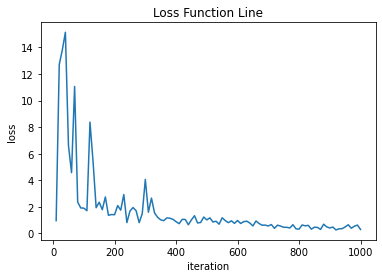

In [31]:
#net = SiameseNetwork().cuda() #定义模型且移至GPU
net = SiameseNetwork()
criterion = ContrastiveLoss() #定义损失函数
optimizer = optim.Adam(net.parameters(), lr = 0.0005) #定义优化器

counter = []
loss_history = [] 
iteration_number = 0


#开始训练
for epoch in range(0, train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1 , label = data
        #img0维度为torch.Size([32, 3, 100, 100])，32是batch，label为torch.Size([32, 3])
        #img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda() #数据移至GPU
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    
show_plot(counter, loss_history)


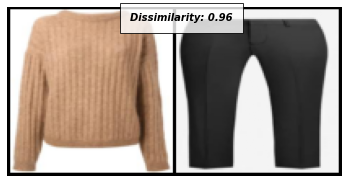

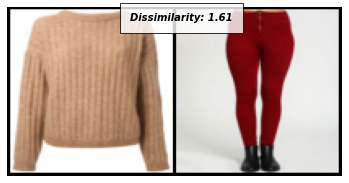

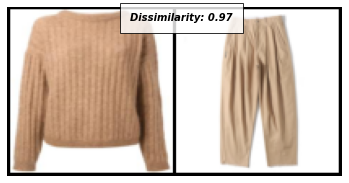

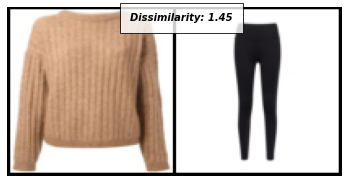

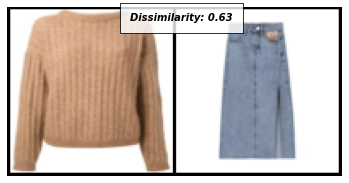

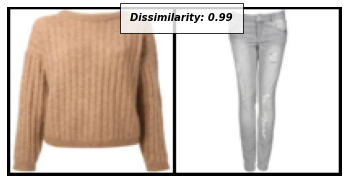

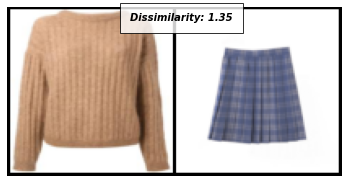

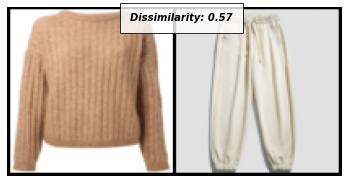

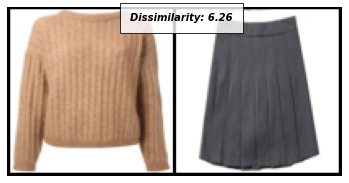

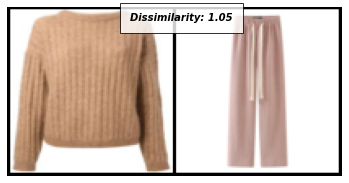

In [63]:
#定义测试的dataset和dataloader

#定义文件dataset
testing_dir1 = "./data2/test/1/"  #上衣测试集地址
folder_dataset_test1 = torchvision.datasets.ImageFolder(root=testing_dir1)

testing_dir2 = "./data2/test/2/"  #上衣测试集地址
folder_dataset_test2 = torchvision.datasets.ImageFolder(root=testing_dir2)

#定义图像dataset
transform_test = transforms.Compose([transforms.Resize((100,100)), 
                                     transforms.ToTensor()])
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset1=folder_dataset_test1,
                                             imageFolderDataset2=folder_dataset_test2,
                                        transform=transform_test,
                                        should_invert=False)

#定义图像dataloader
test_dataloader = DataLoader(siamese_dataset_test,
                            shuffle=True,
                            batch_size=1)


#生成对比图像
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
#     output1,output2 = net(x0.cuda(),x1.cuda())
    output1,output2 = net(x0,x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))